***This is a Reanalysis simulation, this type of simulation does one flight with nominal values***

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
from time import process_time
from rocketpy import Environment, Flight, Rocket, SolidMotor
import datetime
import json

BASE_DIR = Path.cwd()

The functions below manage the parachute opening

In [35]:
# Definition of global variables, to be used inside and outside parachute functions
global last_negative_time, apogee_detected, sampling_rate, parachute_timer
# This variable marks the first instant in which a negative velocity is detected
last_negative_time = None
# This variable indicates whether the algorythm has acknowledged the rocket has reached apogee. A "False" value may mean that negative velocity has not yet been detected, or that it has been detected but has not yet been consistent for enough seconds (the threshold)
apogee_detected = False
# This variable indicates the sampling rate of the recovery activation algorythm
sampling_rate = 105
# This variable keeps track of the flight time from ignition to the first recovery event 
parachute_stopwatch = 0

# The following function is a Python representation of the C code that will be used on the rocket to detect the apogee condition. In the actual code, detection of negative velocity is achieved thanks to the readings from the IMU sensor


def check_apogee(vertical_velocity, current_time, threshold=0.1):

    global last_negative_time, apogee_detected, parachute_stopwatch

    # If the parachute activation signal has already been sent, confirm it and exit the function
    if apogee_detected:
        return True, last_negative_time
    
    # Otherwise, check if the rocket is losing altitude
    if vertical_velocity < 0:

        # if a descent is being detected, check if this is the first time this occurs
        if last_negative_time is None:

            # if it is, mark this instant and exit the function
            last_negative_time = parachute_stopwatch
            return False, last_negative_time
        
        elif (current_time - last_negative_time) >= threshold: #0.1s

            # if it isn't and enough time has passed with a continuous descent, acknowledge apogee and exit the function
            return True, last_negative_time
        
        else:

            # if it isn't and not enough time has passed with a continuous descent, return False and exit the function
            return False, last_negative_time
        
    # if a descent is no longer being (or has never been) detected, return False and exit the function
    else:
        return False, None
    

# The following function is a Python representation of the C code that will be used on the rocket to detect the main parachute opening condition. In the code, the height is determined by filtering barometer readings with a Kalman filter
 

def main_parachute_opening(apogee_detected:bool, altitude:float) -> bool:
    return apogee_detected and altitude <= 450.0 # meters 


# Set up parachute trigger for the drogue chute
def simulator_check_drogue_opening(p, h, y):
    global last_negative_time, apogee_detected, parachute_stopwatch, sampling_rate
    altitude = h
    vertical_velocity = y[5]

    # Update counter for flight time to apogee: each time this function is called, the timer advances of 1 over the frequency at which the function is called. This is a workaround to get a measure of in-flight time
    # into the apogee detection algorythm and successfully implement its "consistent descent signal" principle.
    parachute_stopwatch += 1/sampling_rate

    # Mark instant at which the current call is being made
    now = parachute_stopwatch
    
    # Call apogee detection algorythm
    apogee_detected, last_negative_time = check_apogee(
        vertical_velocity,
        now,  
    )
    return apogee_detected

# Set up parachute trigger for the main chute
def simulator_check_main_opening(p, h, y):
    global last_negative_time, apogee_detected
    altitude = h

    # Call parachute activation algorythm and return its output value
    return main_parachute_opening(apogee_detected, altitude)


**Lets define the Environment**
- Geographical Coordinates
- Ground elevation ASL (above sea level) 
- Date & Time (UTC if not specified)
- Max expected flight elevation

In [36]:
Env = Environment(
    date = (2024, 10, 13, 16),#(Year, Month, Day, Hour UTC)
    longitude=-8.288963, latitude=39.3897,
    elevation = 160,
    max_expected_height = 4500
)

There are 3 possible choices of weather data:
1. A custom atmosphere defined with the mean environment values calculated in the week on EuRoC from 2005 to 2024 between the 10th and the 15th october. In order to define the mean environment features, we used the built-in function "Environment Analysis" from RocketPy. This generates a .json file with the mean environment values based on  a sample of 19 years, from 2005 to 2024, between the 10th and 15th of October, by feeding the NetCDF4 data from Copernicus. The .json file contains a series of .csv profiles based on the altitude that define pressure, temperature and wind vectors on an hourly basis. For more information consult the "mean_environment_values.json" file inside the directory.

2. Select a date during the EuRoC week: October 10th-15th from 2005 to 2024 (change the date in the environment definition), in this case the weather data will match the date chosen by the user.

3. The Forecast: let the user simulate in the future by using the GFS (Global Forecast System) weather data, (change the date in the environment definition).


In [ ]:
# we need to import the .json with the mean environment values oustide the defition of the atmospheric model

with open(BASE_DIR /"""environment_data/mean_environment_values.json""", "r") as f:
    data = json.load(f)

**MEAN ENVIRONMENT VALUES**

In [38]:
Env.set_atmospheric_model(
    
    # set the atmosphere model
    type="custom_atmosphere",

    # define the values (pressure, temperature and wind [E,N]) from the .json
    pressure = data["atmospheric_model_pressure_profile"][str(Env.date[3])],
    temperature= data["atmospheric_model_temperature_profile"][str(Env.date[3])],
    wind_u= data["atmospheric_model_wind_velocity_x_profile"][str(Env.date[3])],
    wind_v= data["atmospheric_model_wind_velocity_y_profile"][str(Env.date[3])]

    )

**EUROC DATE OCTOBER 10th-15th 2005-2024**

In [ ]:
# Env.set_atmospheric_model(    
#     type="Ensemble",                                                                                                  
#     file=str(BASE_DIR / """environment_data/SantaMargarida_Ensemble_09to16oct2010to2024.nc"""),                                        
#     # This section creates an updated dictionary to read the NetCDF4 files,                                           
#     # as the built-in ECMWF dictionary inside RocketPy is outdated and can't read NetCDF4 files in the new format     
#     dictionary= {                                                                                                     
#         "ensemble": "number",                                                                                         
#         "time": "valid_time",                                                                                         
#         "latitude": "latitude",                                                                                       
#         "longitude": "longitude",                                                                                     
#         "level": "pressure_level",                                                                                    
#         "temperature": "t",                                                                                           
#         "surface_geopotential_height": None,                                                                          
#         "geopotential_height": None,                                                                                  
#         "geopotential": "z",                                                                                          
#         "u_wind": "u",                                                                                                
#         "v_wind": "v",                                                                                                
#     },
# )

**FORECAST**

In [40]:
# Env.set_atmospheric_model(
#     type="Forecast",
#     file="GFS"
# )

**DEFINE THE ROCKET PARTS**

Motor


In [ ]:
Pro75_9977M2245 = SolidMotor(
    thrust_source=str(BASE_DIR/"""Cesaroni_9977_M2245.csv"""),
    dry_mass=0,
    dry_inertia=(0, 0, 0),
    nozzle_radius=29 / 1000,
    grain_number=6,
    grain_density=1758.7,
    grain_outer_radius= 35.9/ 1000,
    grain_initial_inner_radius=18.1/ 1000,
    grain_initial_height=156.17 / 1000,
    grain_separation=3 / 1000,
    grains_center_of_mass_position=0.5125,
    center_of_dry_mass_position=0,
    nozzle_position=0,
    burn_time=(0.136, 4.3),
    throat_radius=20/ 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

Rocket Body

In [42]:
Atlas = Rocket(
    radius=75 / 1000,
    mass=22.740,
    inertia=(14.631,14.631,0.075),
    power_off_drag=str(BASE_DIR/"""Hexagonal_power_off.csv"""),
    power_on_drag=str(BASE_DIR/"""Hexagonal_power_on.csv"""),
    center_of_mass_without_motor=1.61919,
    coordinate_system_orientation="nose_to_tail",
)
Atlas.add_motor(Pro75_9977M2245, position=3.08)

Rail Buttons


In [43]:
Rail_Buttons = Atlas.set_rail_buttons(
    upper_button_position=0.57,
    lower_button_position=2.14,
    angular_position=0,
)

Nose Cone

In [44]:
nose_cone = Atlas.add_nose(
    length=0.43, 
    kind="vonKarman", 
    position=0
)

Fins

In [45]:
fin_set = Atlas.add_trapezoidal_fins(
    n=3,
    root_chord=0.28,
    tip_chord=0.06,
    span=0.142,
    position=2.71,
    cant_angle=0,
    sweep_angle=58.2,
)

Boat Tail

In [46]:
tail = Atlas.add_tail(
    top_radius=0.075, bottom_radius=0.05, length=0.075, position=3.005,
)

Parachutes

In [47]:
Main = Atlas.add_parachute(
    "Main",
    cd_s=0.97*10.5070863,
    trigger=simulator_check_main_opening,
    sampling_rate=105,
    lag=1.73,
    noise=(0, 6.5, 0.3),
)

Drogue = Atlas.add_parachute(
    "Drogue",
    cd_s=0.97*0.6566929,
    trigger=simulator_check_drogue_opening,
    sampling_rate=105,
    lag=1.73,
    noise=(0, 6.5, 0.3),
)

Rocket's info

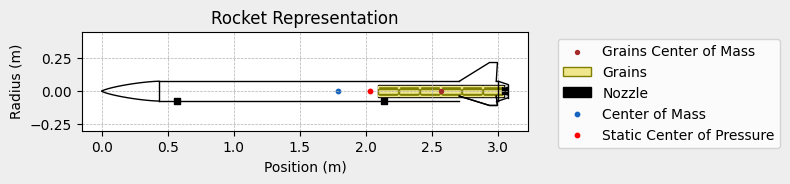

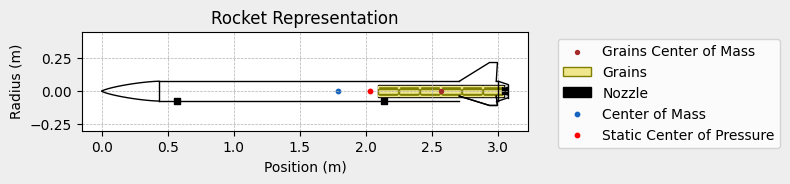

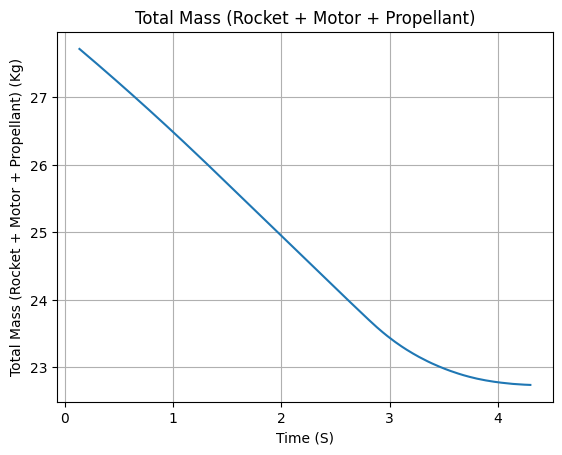

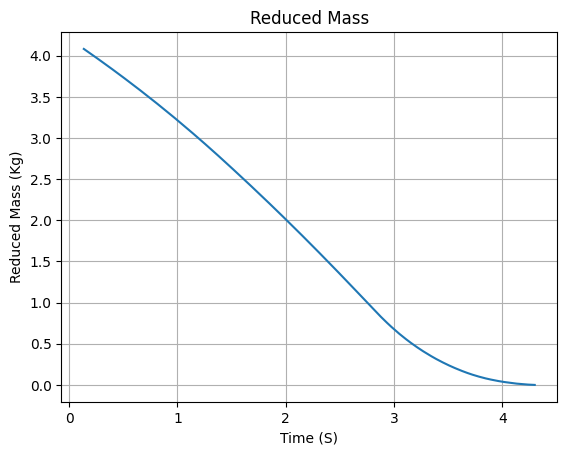

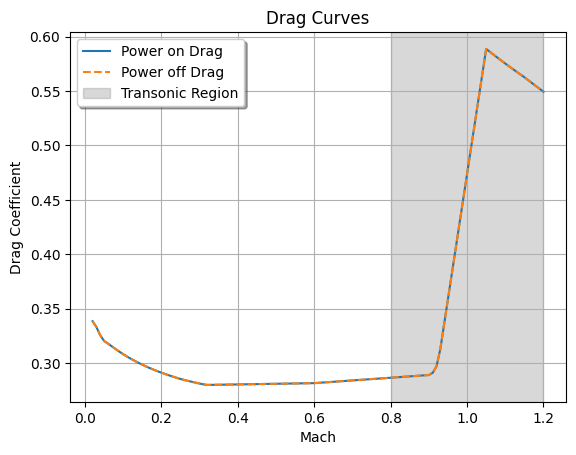

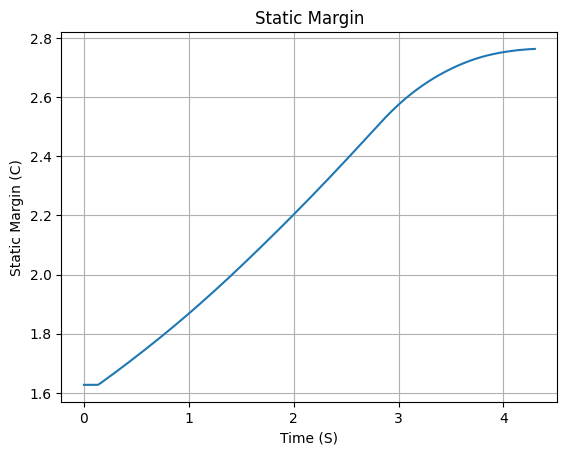

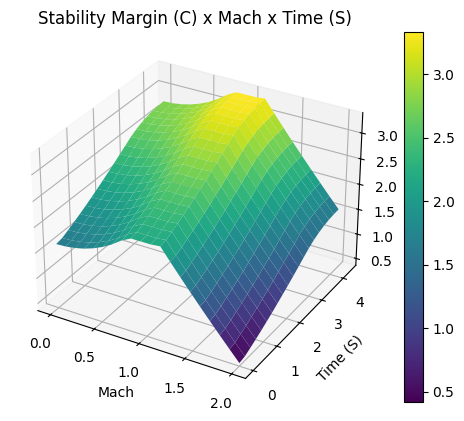

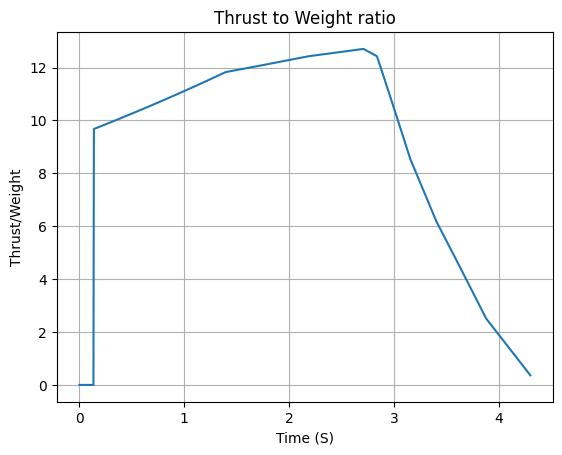

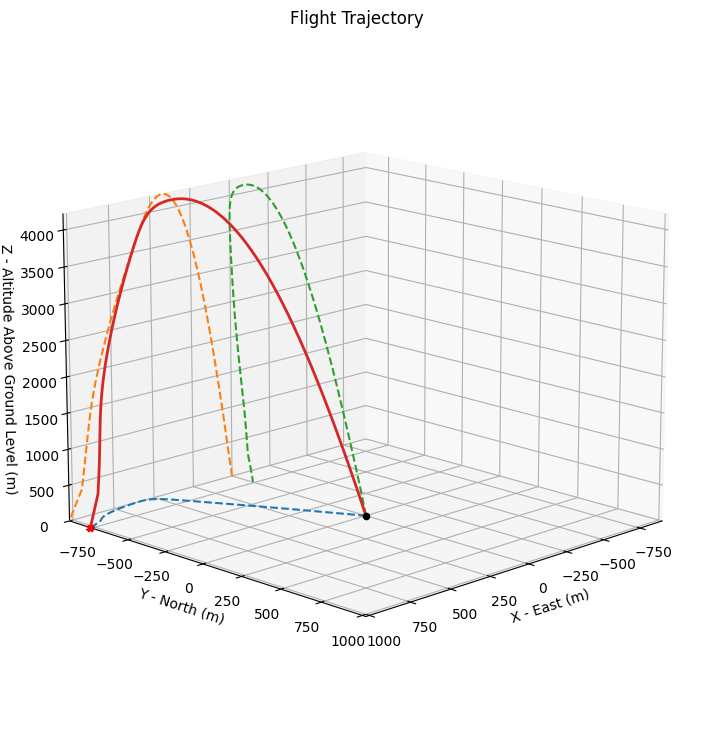

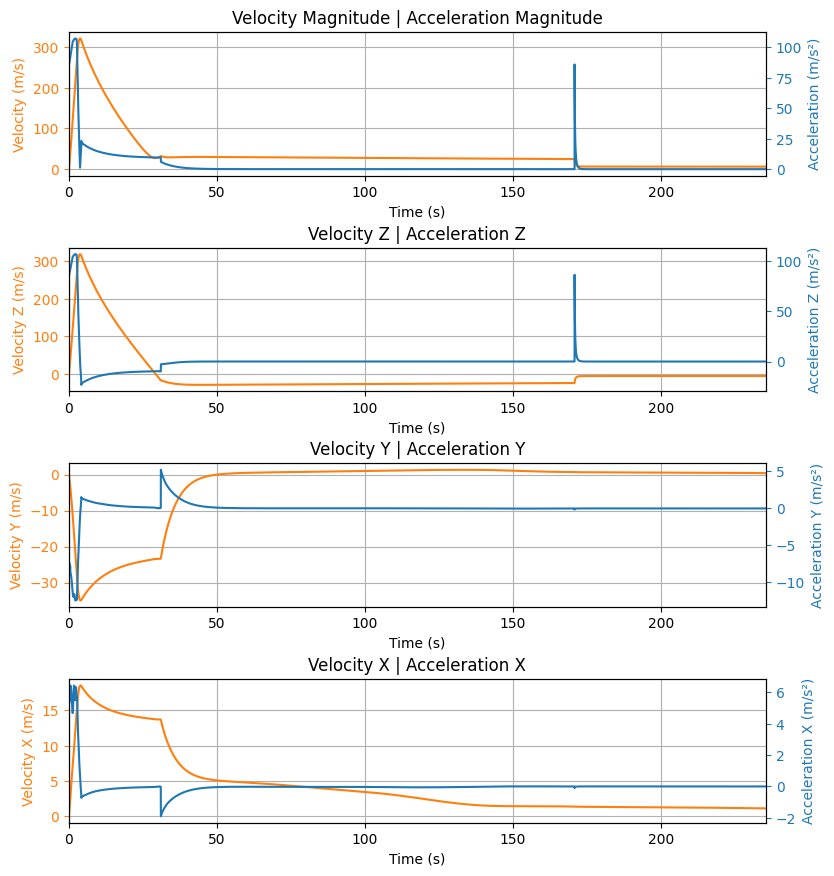

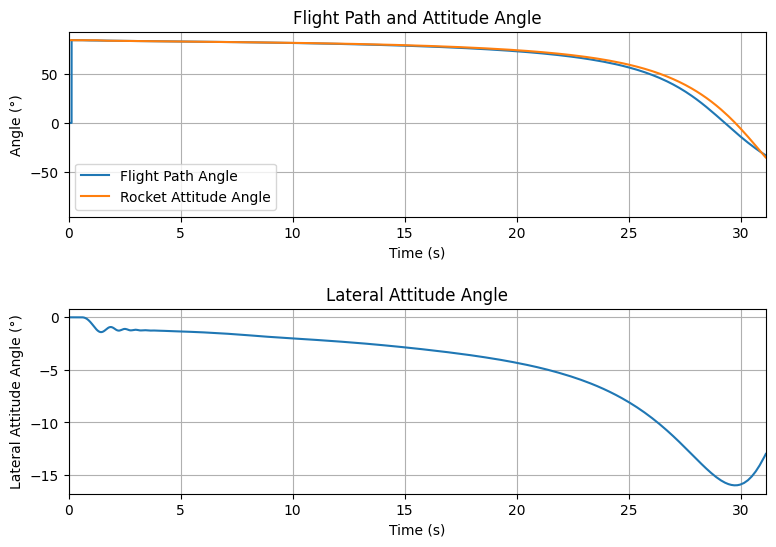

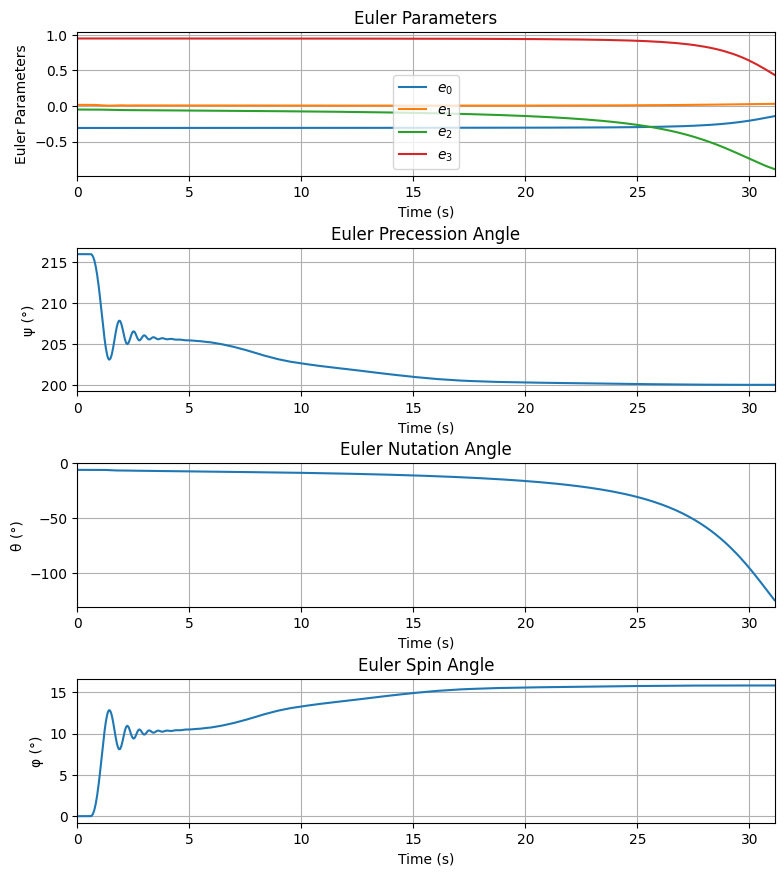

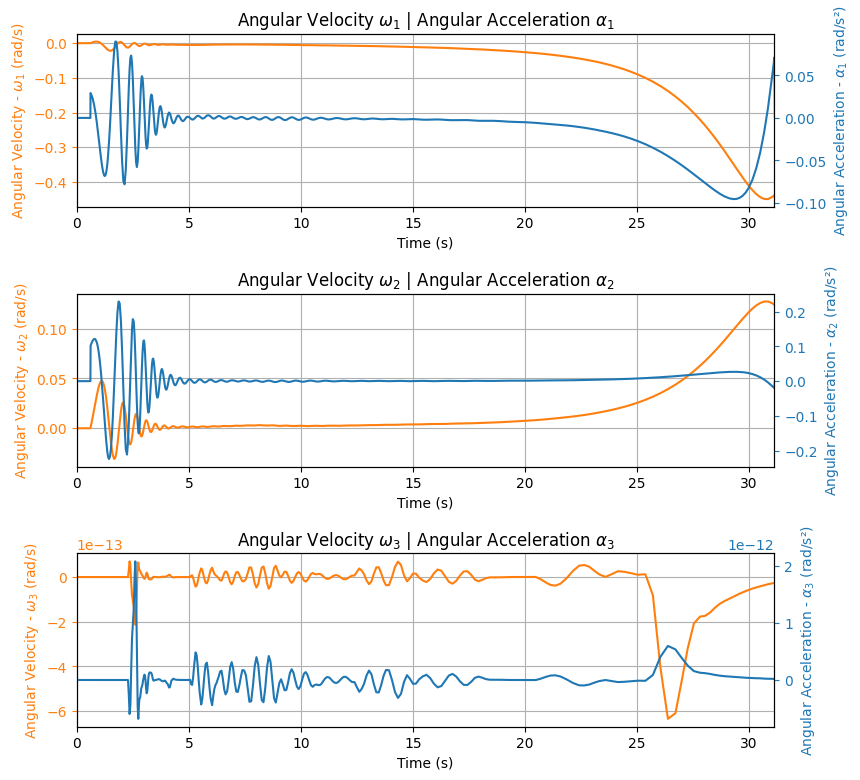

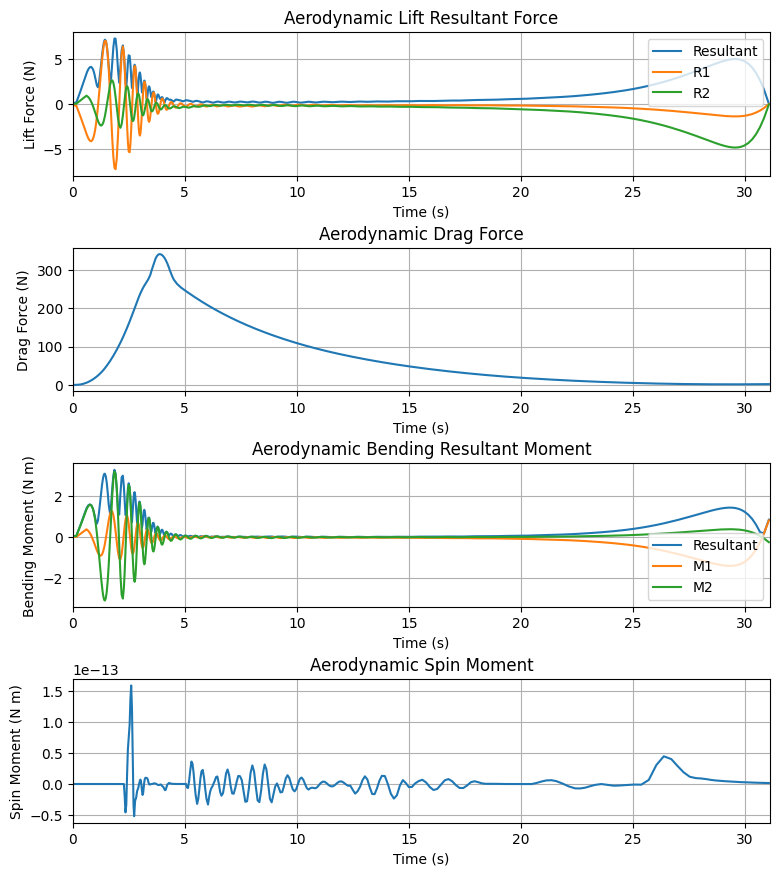

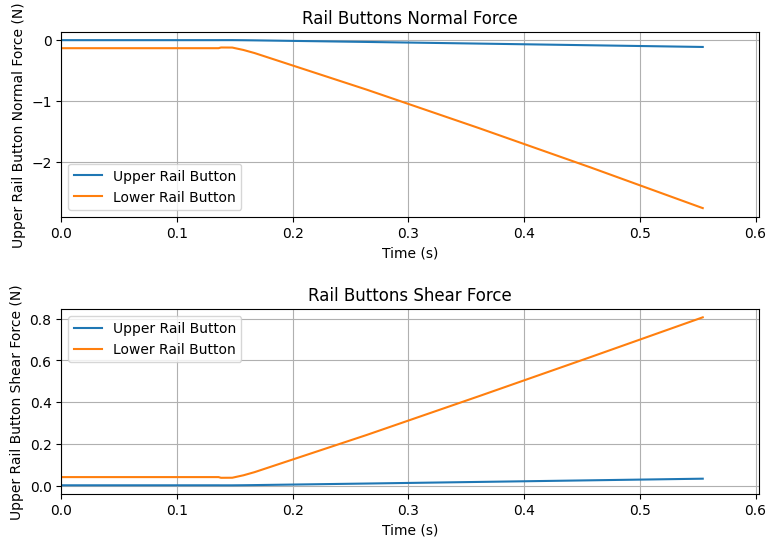

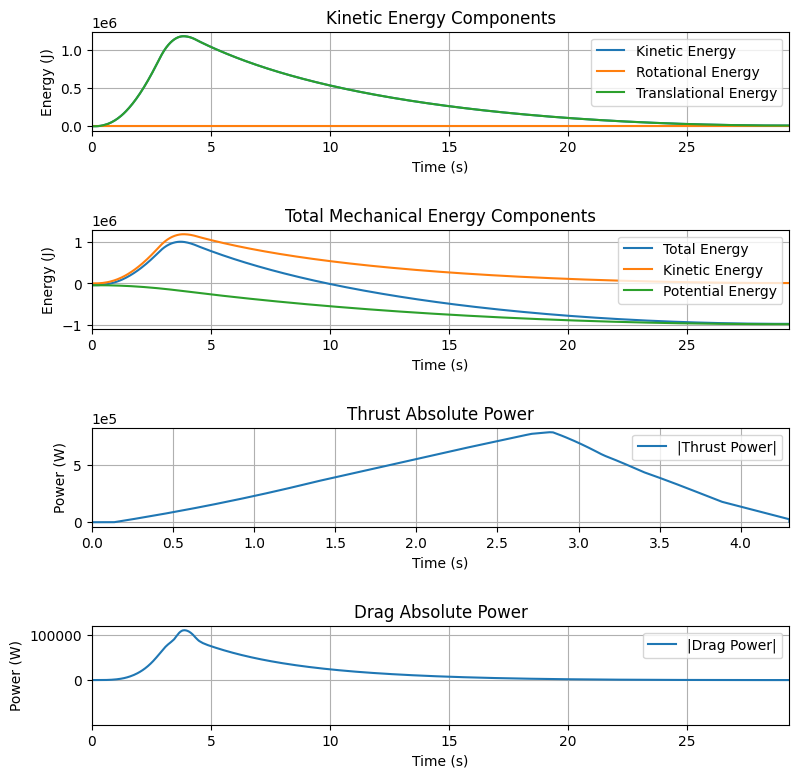

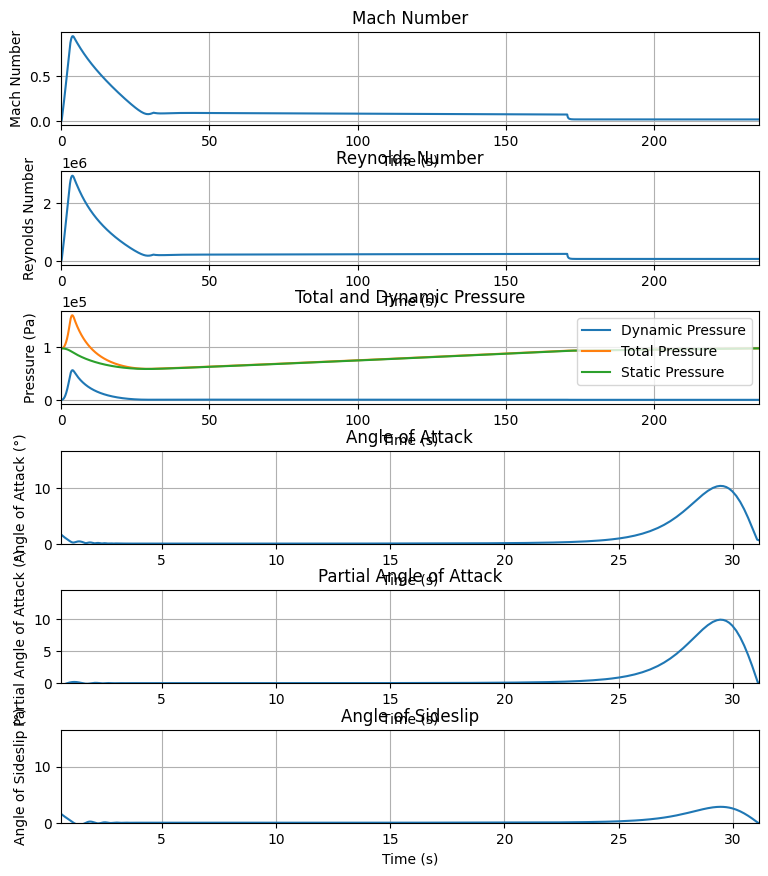

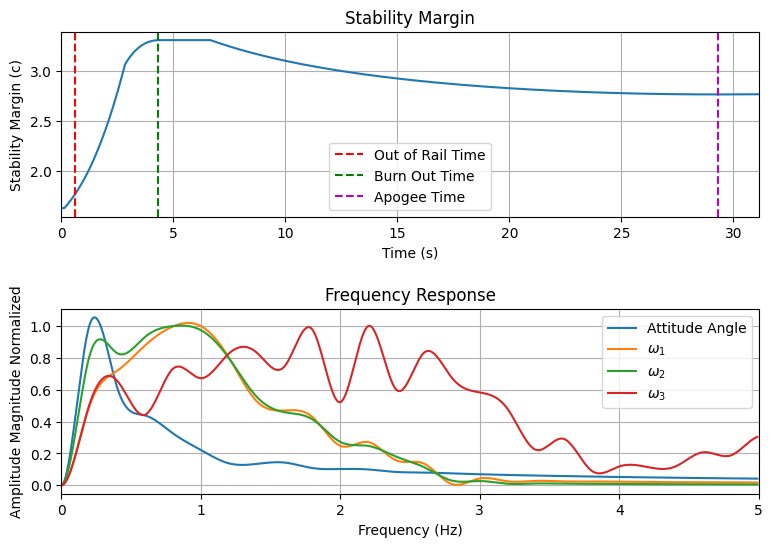

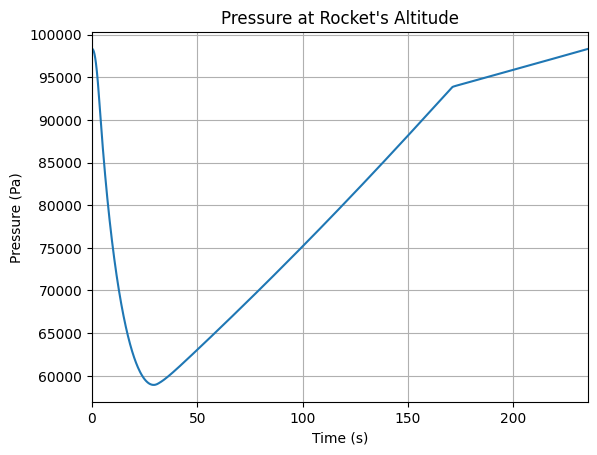

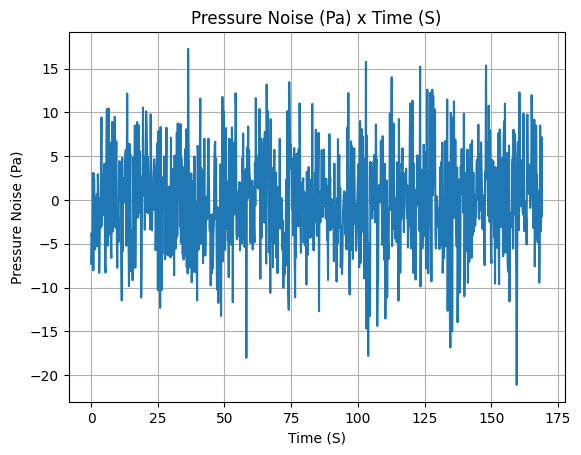

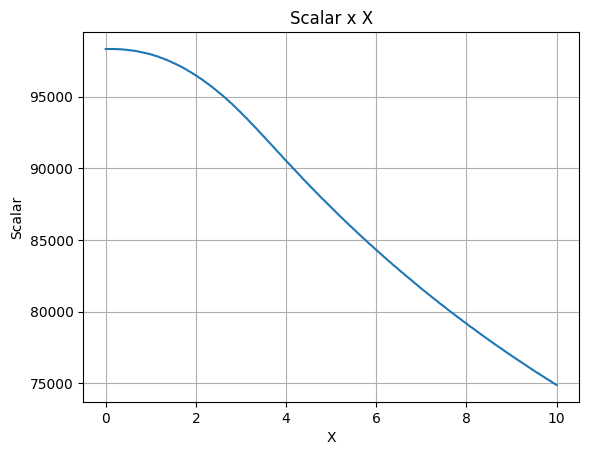

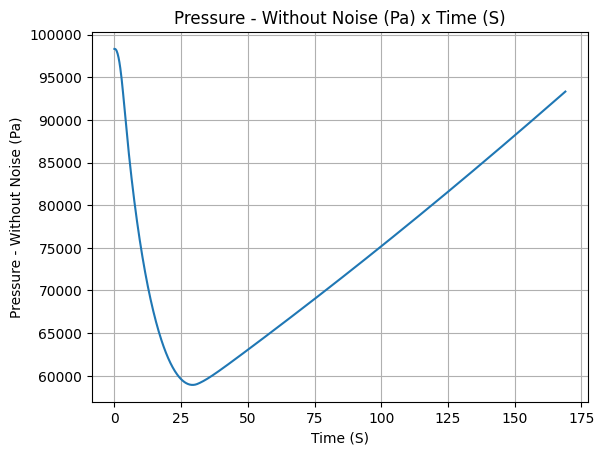

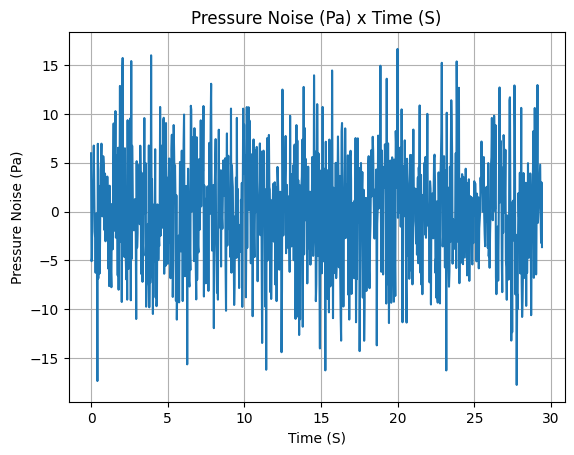

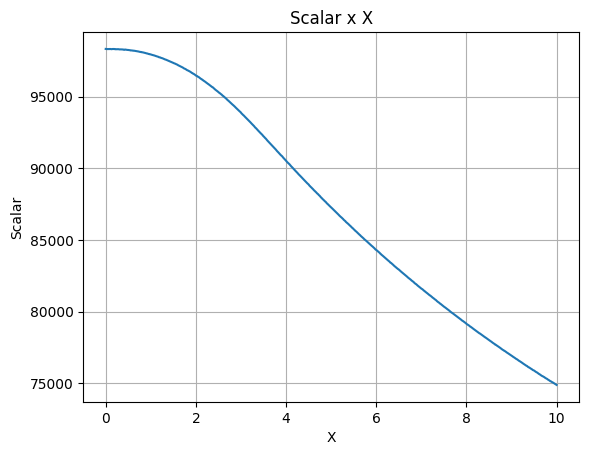

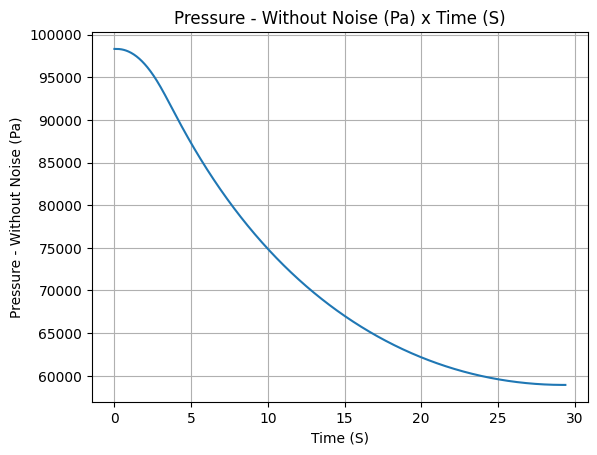

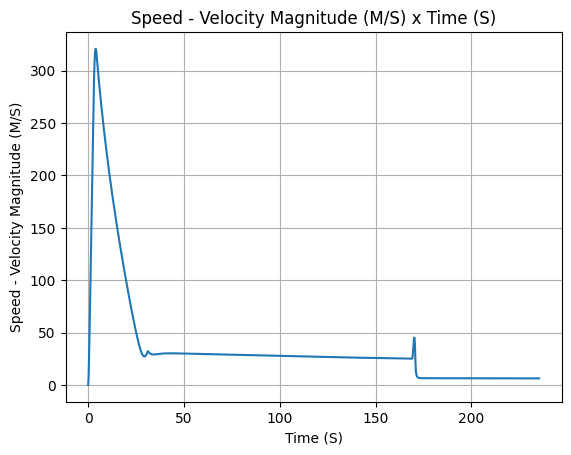

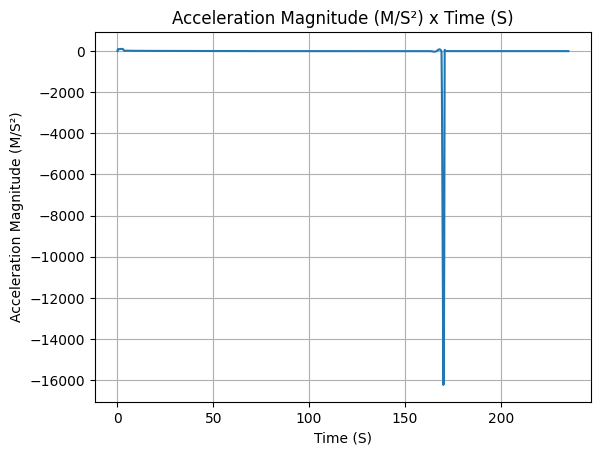

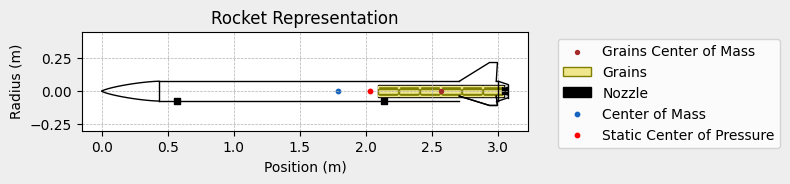


Inertia Details

Rocket Mass: 22.740 kg (without motor)
Rocket Dry Mass: 22.740 kg (with unloaded motor)
Rocket Loaded Mass: 27.716 kg
Rocket Structural Mass Ratio: 0.820
Rocket Inertia (with unloaded motor) 11: 14.631 kg*m2
Rocket Inertia (with unloaded motor) 22: 14.631 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.075 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.075 m
Rocket Frontal Area: 0.017671 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.000 m
Rocket Center of Dry Mass - Nozzle Exit: 1.461 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.948 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.170 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 5.837/rad
Tail Lift Coefficient D

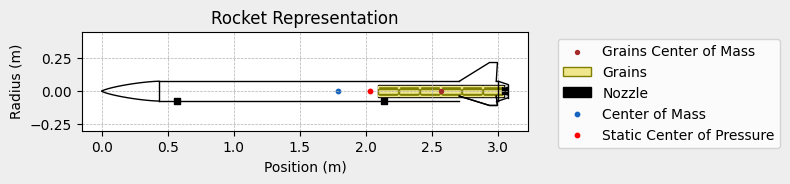


Mass Plots
----------------------------------------


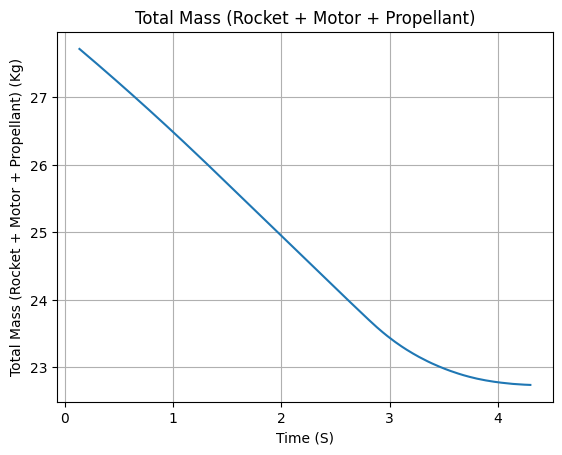

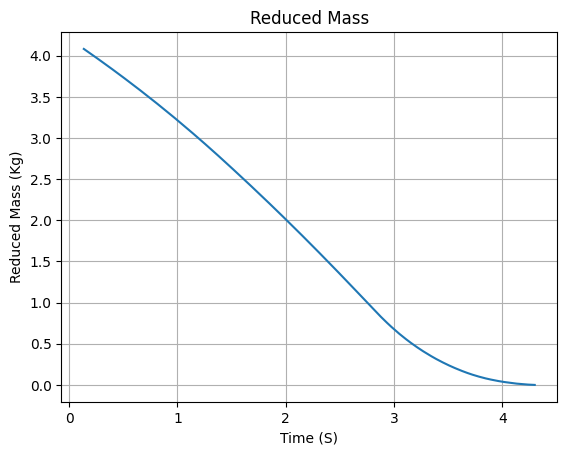


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


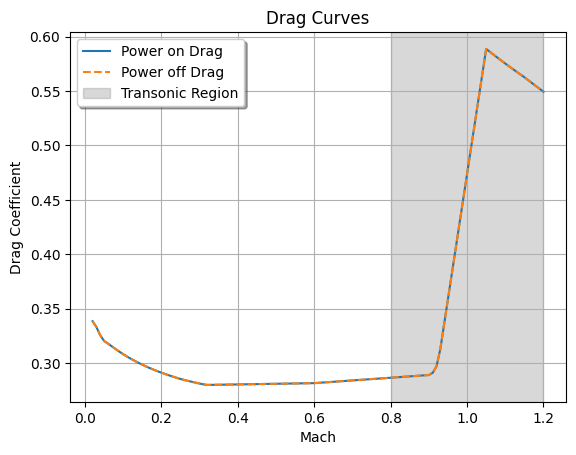


Stability Plots
--------------------


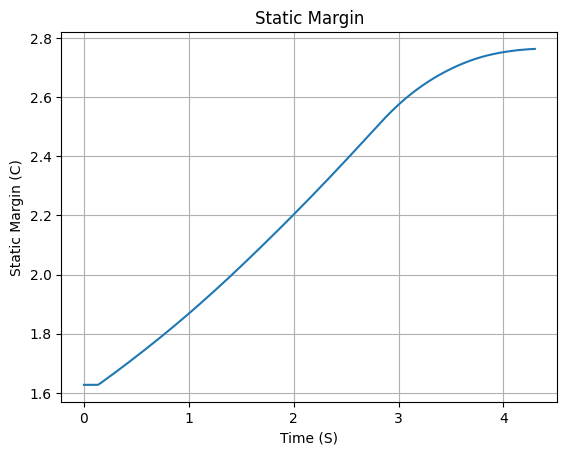

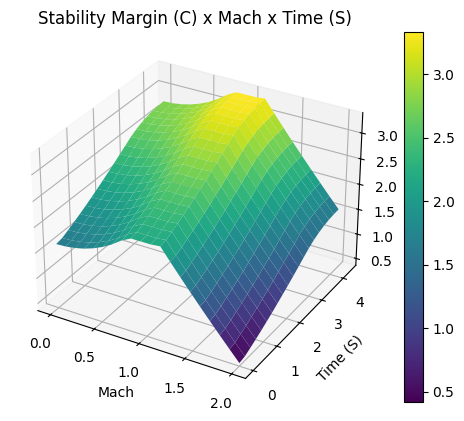


Thrust-to-Weight Plot
----------------------------------------


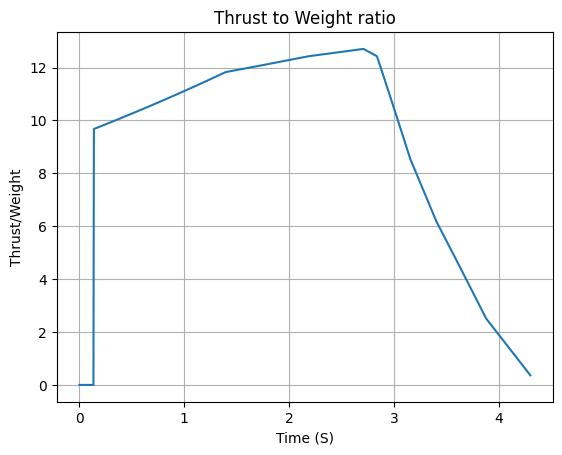

In [48]:
Atlas.draw()
Atlas.all_info()

Flight & info


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 160.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: -0.309 | e1: 0.016 | e2: -0.050 | e3: 0.950
Euler Angles - Spin φ : -0.00° | Nutation θ: -6.00° | Precession ψ: 216.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 1.627 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.33 m/s
Lateral Surface Wind Speed: 1.12 m/s


Launch Rail

Launch Rail Length: 12 m
Launch Rail Inclination: 84.00°
Launch Rail Heading: 144.00°


Rail Departure State

Rail Departure Time: 0.603 s
Rail Departure Velocity: 41.420 m/s
Rail Departure Stability Margin: 1.763 c
Rail Departure Angle of Attack: 1.633°
Rail Departure Thrust-Weight Ratio: 10.430
Rail Departure Reynolds Number: 3.951e+05


Burn out State

Burn out time: 4.300 s
Altitude at burn out: 962.984 m (ASL) | 802.984 m (AGL)
Rocket speed at burn out: 316.967 m/s
Freestream vel

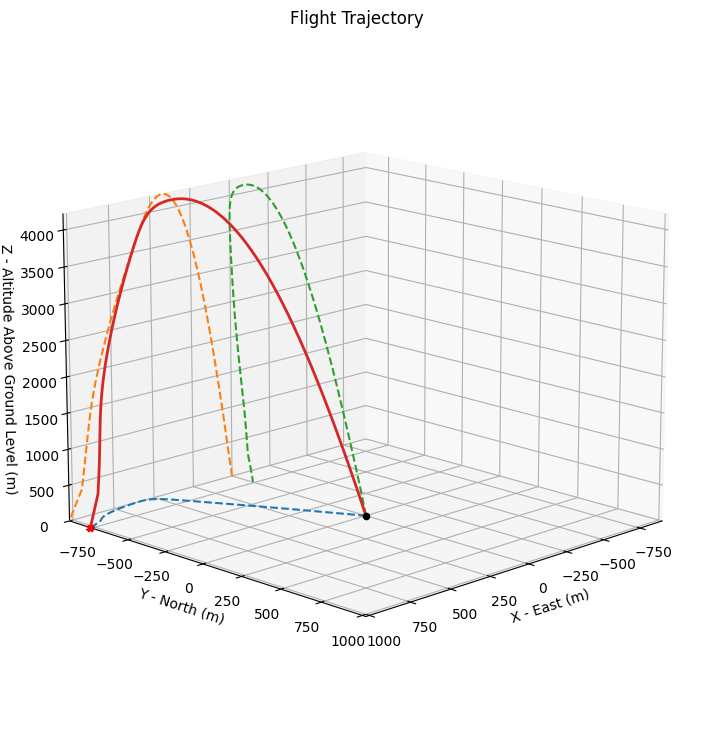



Trajectory Kinematic Plots



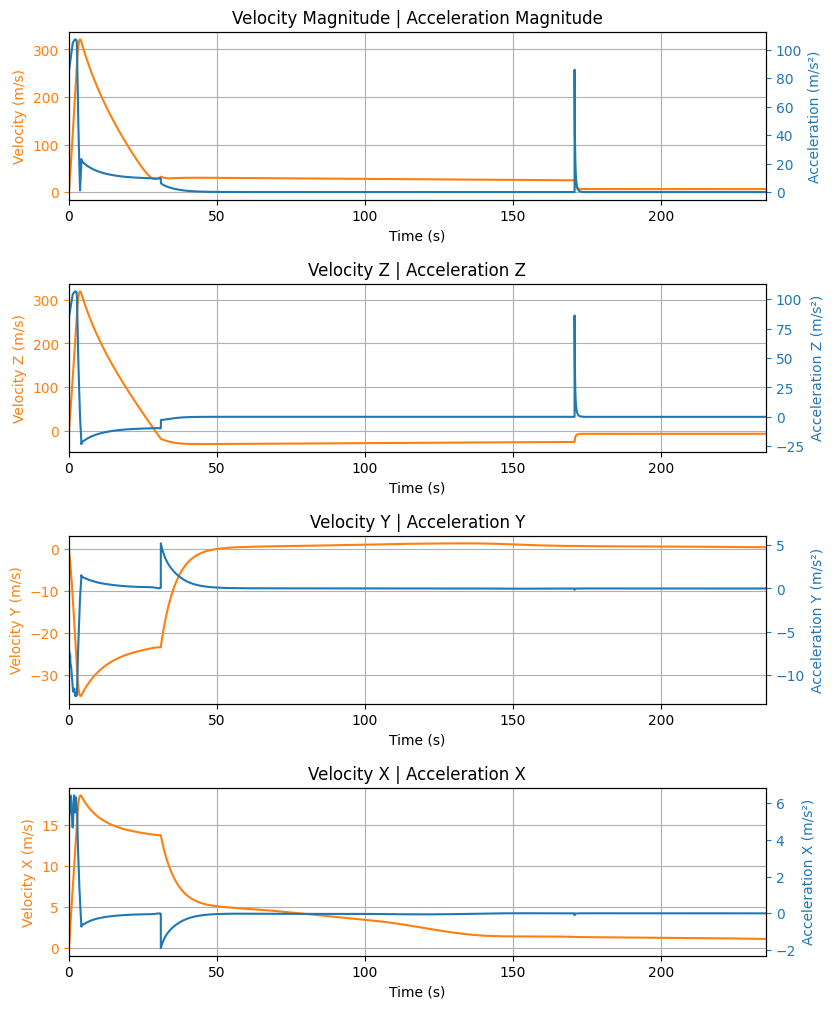



Angular Position Plots



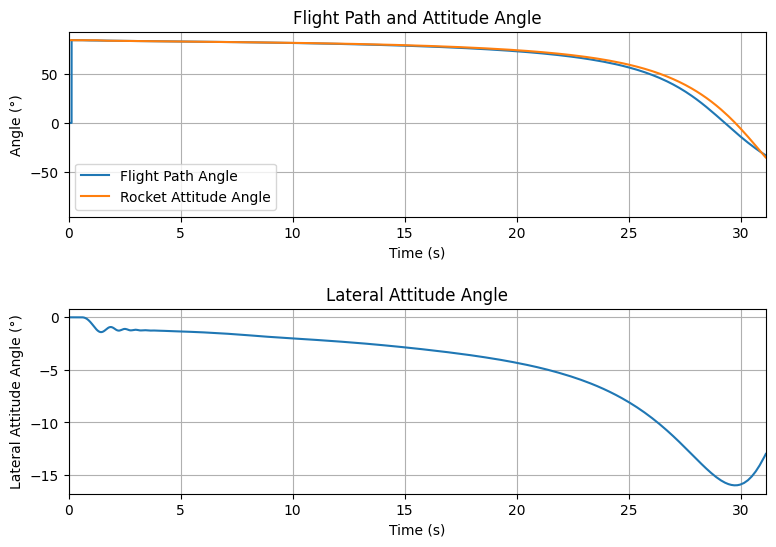



Path, Attitude and Lateral Attitude Angle plots



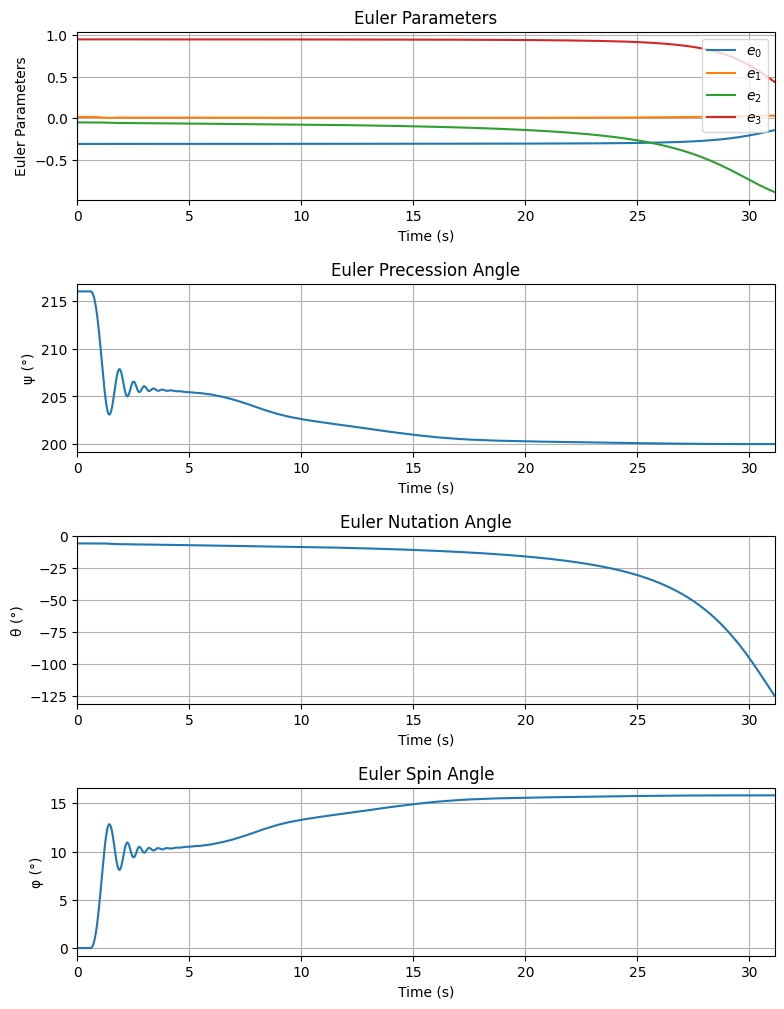



Trajectory Angular Velocity and Acceleration Plots



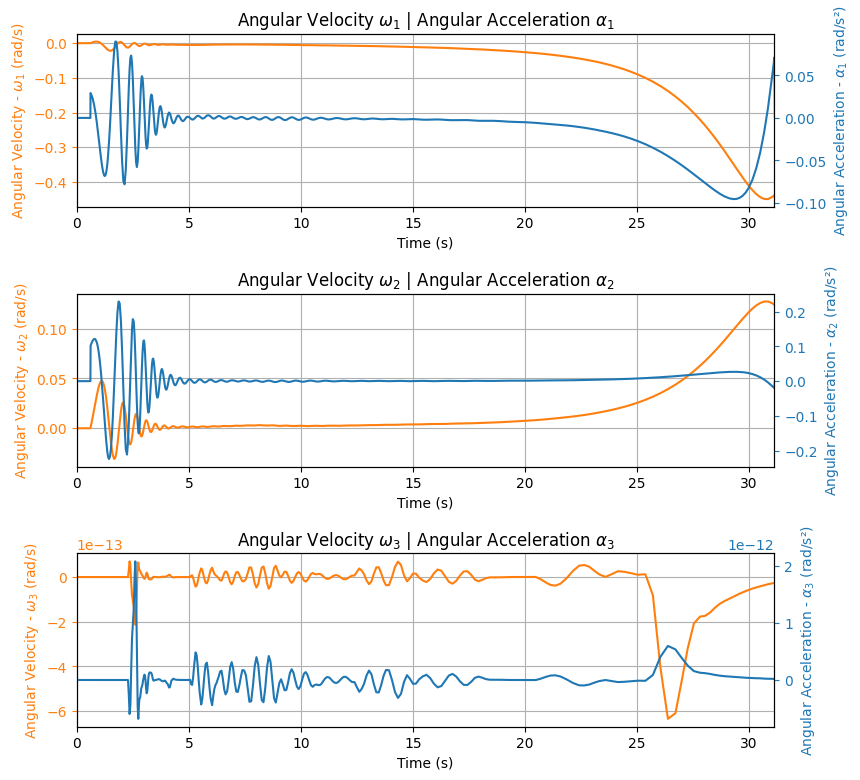



Aerodynamic Forces Plots



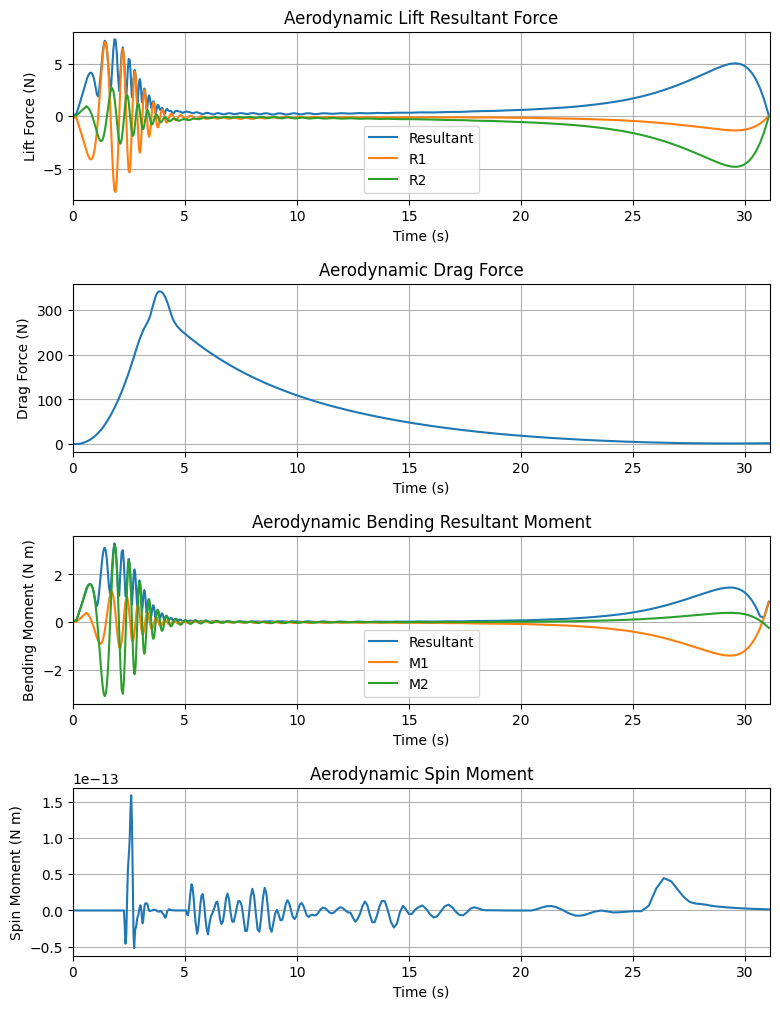



Rail Buttons Forces Plots



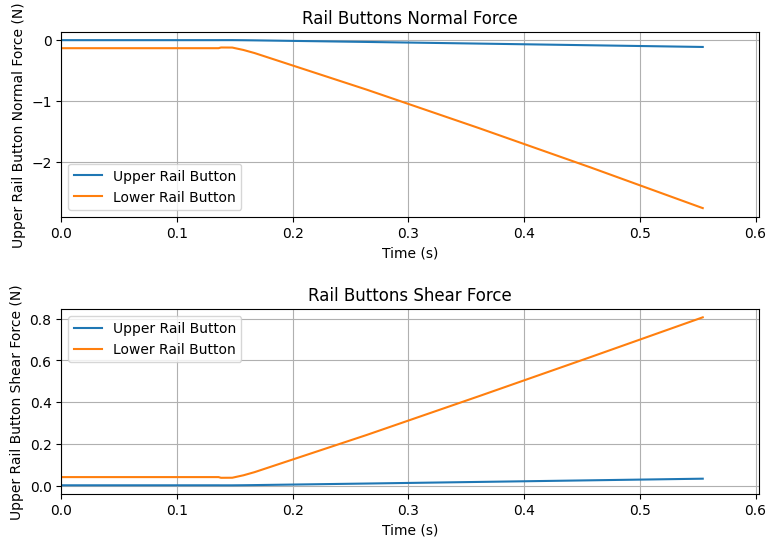



Trajectory Energy Plots



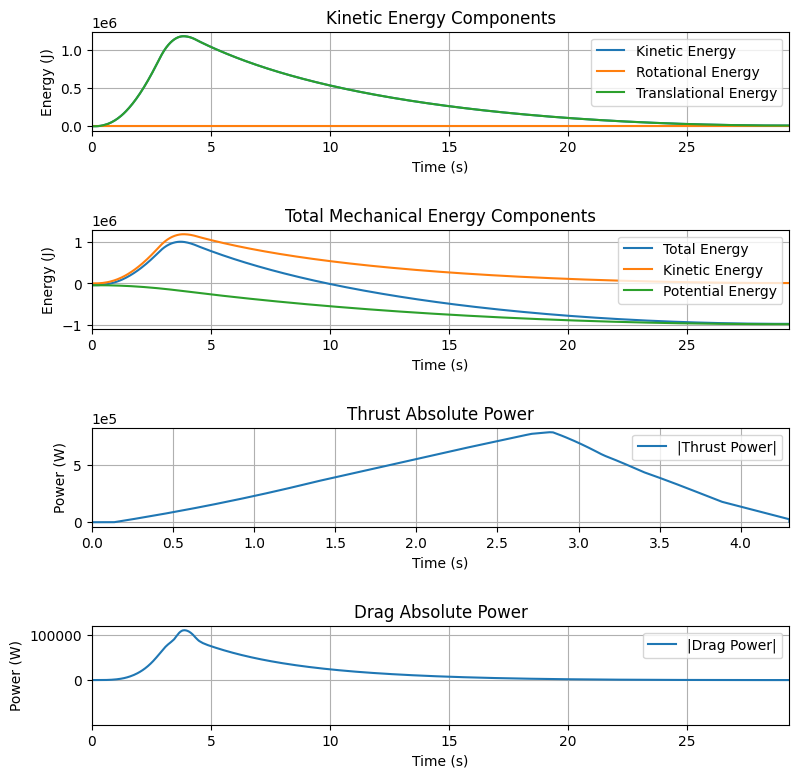



Trajectory Fluid Mechanics Plots



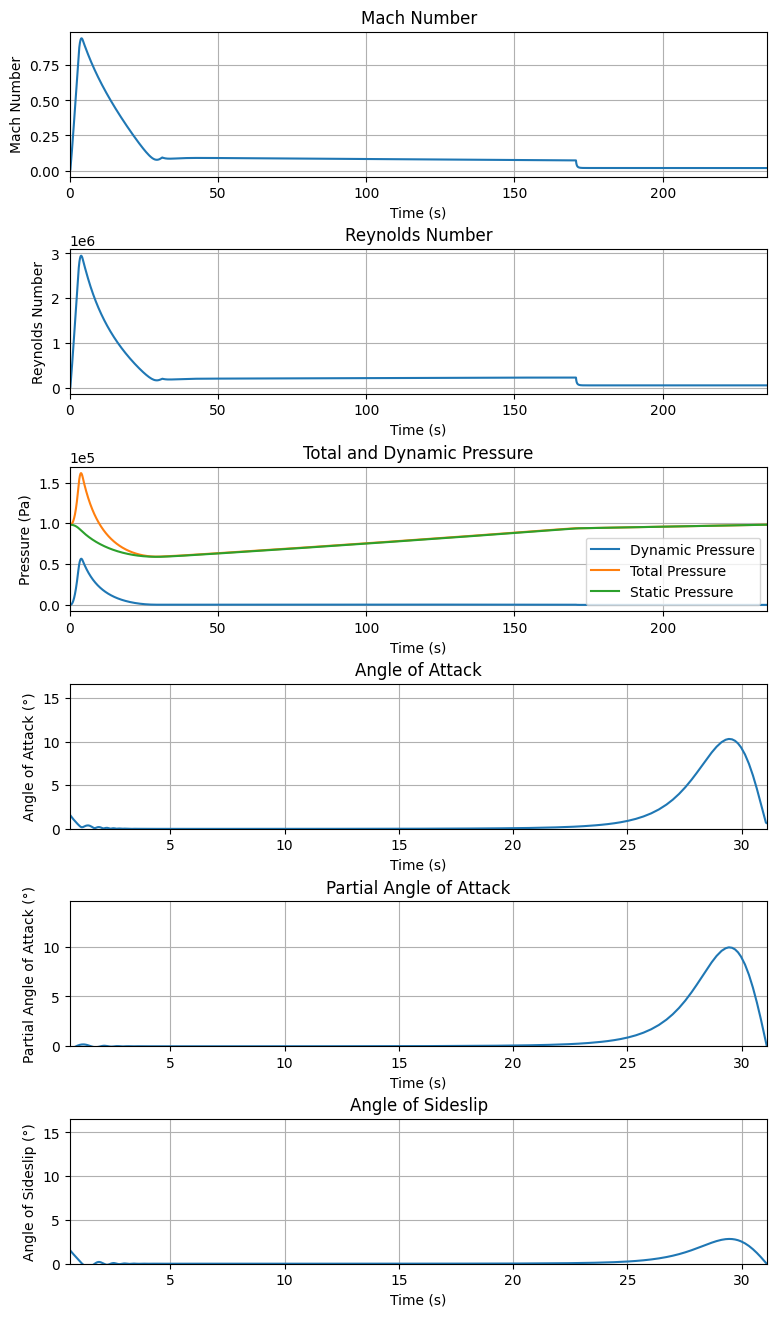



Trajectory Stability and Control Plots



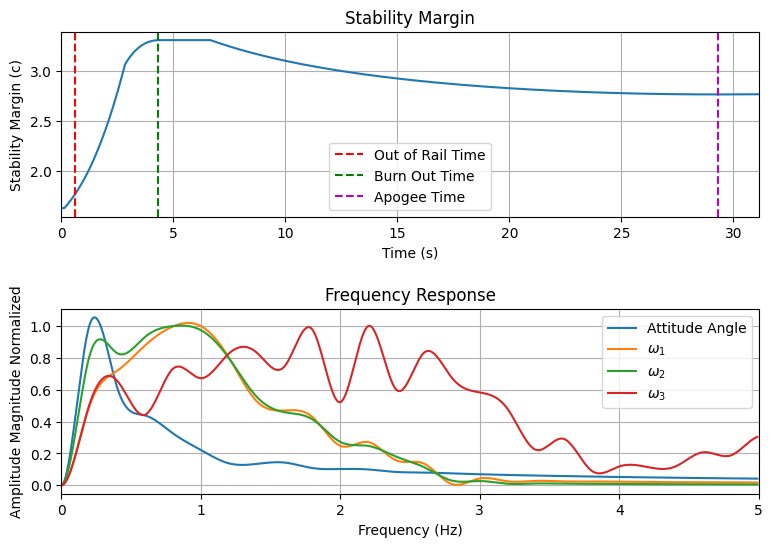



Rocket and Parachute Pressure Plots



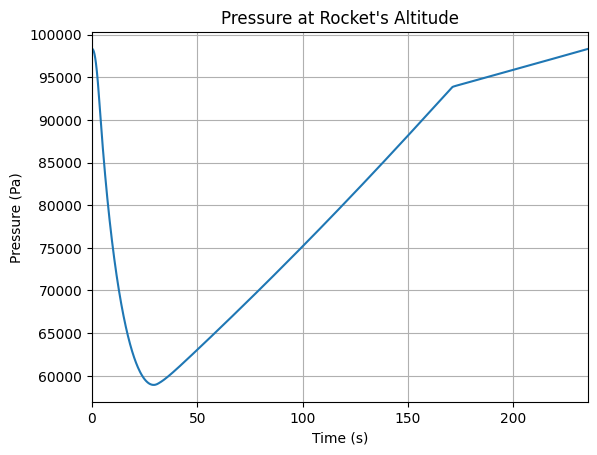


Parachute:  Main


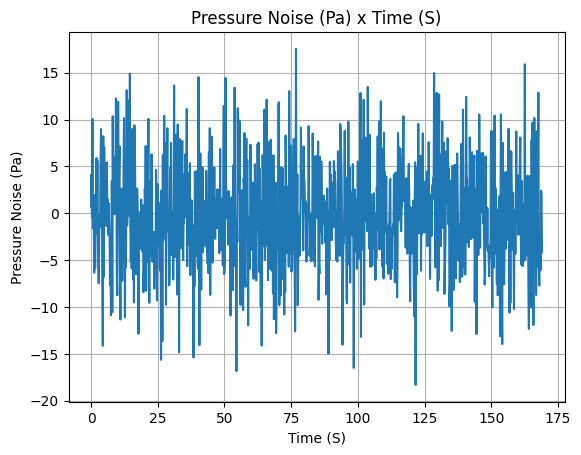

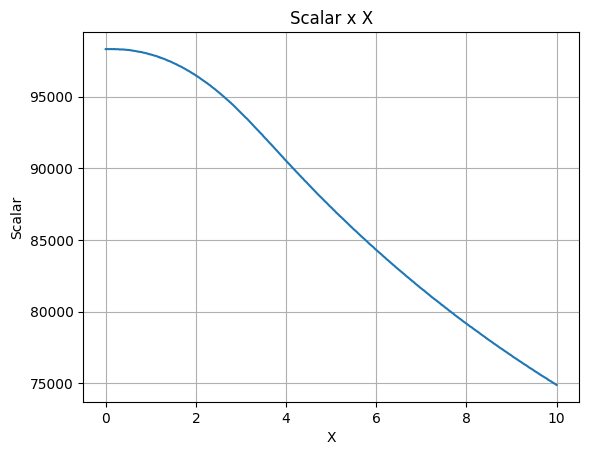

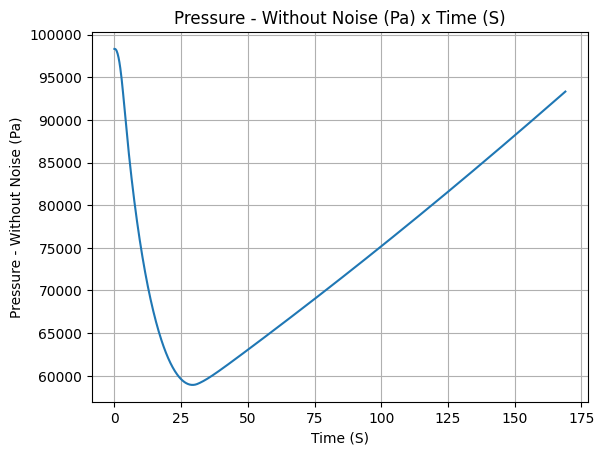


Parachute:  Drogue


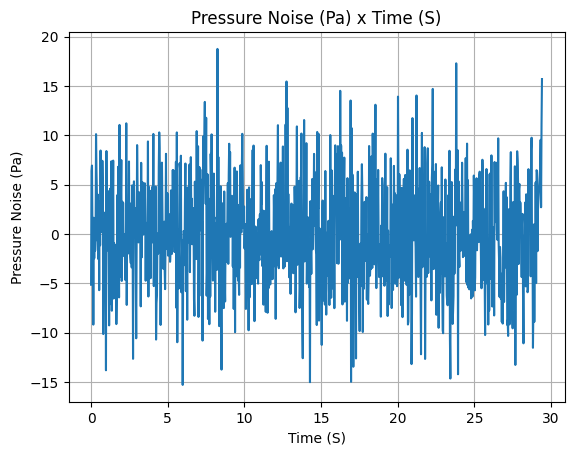

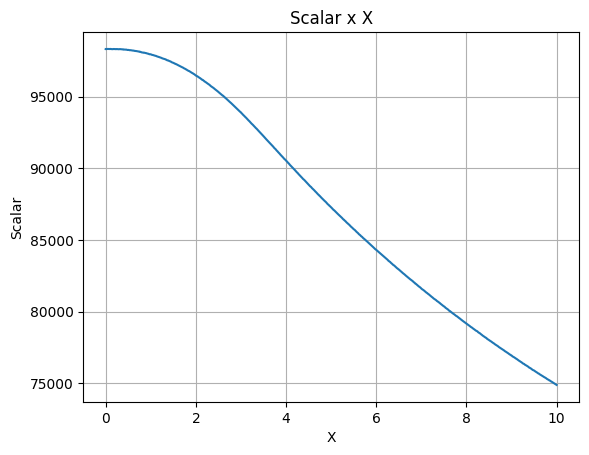

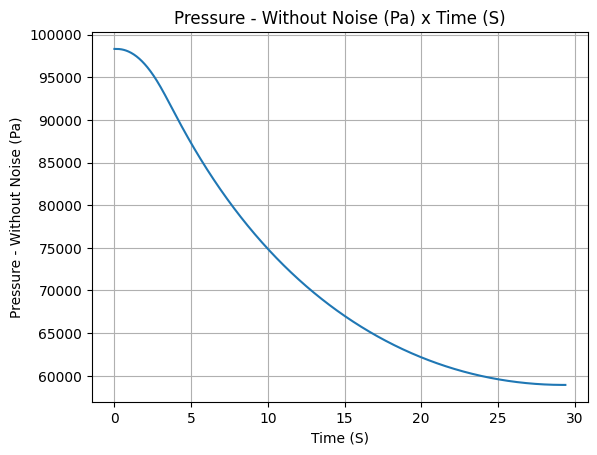

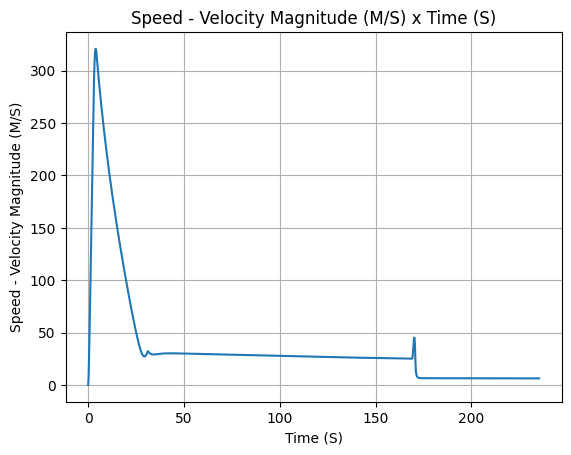

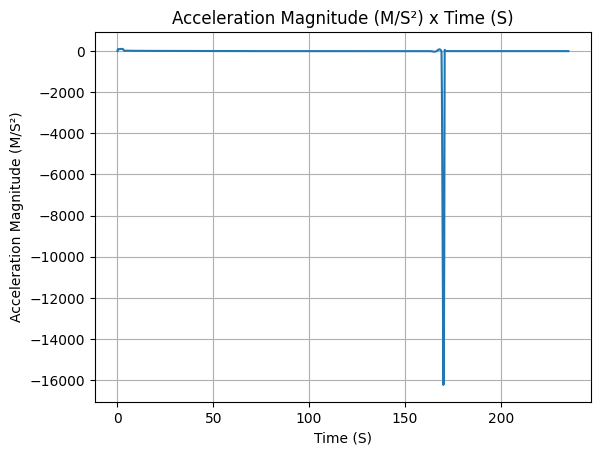

In [49]:
rocket_flight = Flight(
    rocket=Atlas, environment=Env, rail_length=12, inclination=84, heading=144
)

rocket_flight.all_info()

rocket_flight.speed()
rocket_flight.acceleration()



Save and export trajectory, the format .kml can be open on google earth

In [50]:

rocket_flight.export_kml(
    file_name=str(BASE_DIR/"trajectory.kml"),
    extrude=True,
    altitude_mode="relative_to_ground",
)

File  c:\Users\eugen\Documents\AuroraRocketry\Atlas\Atlas_v1.0_sim_hexagonal\trajectory.kml  saved with success!
